BloomTech Data Science

*Unit 2, Sprint 1, Module 3*

---

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Ridge Regression

For this project, you'll return to the Tribecca Condo dataset. But this time, you'll look at the _entire_ dataset and try to predict property sale prices.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function to engineer two subset your dataset to one-family dwellings whose price is between \\$100,000 and \\$2,000,000.
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline mean absolute error for your dataset.
- **Task 6:** Build and train a `OneHotEncoder`, and transform `X_train` and `X_test`.
- **Task 7:** Build and train a `LinearRegression` model.
- **Task 8:** Build and train a `Ridge` model.
- **Task 9:** Calculate the training and test mean absolute error for your `LinearRegression` model.
- **Task 10:** Calculate the training and test mean absolute error for your `Ridge` model.
- **Task 11:** Create a horizontal bar chart showing the 10 most influencial features for your `Ridge` model. 

**Note**

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

# I. Wrangle Data

In [2]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder
import numpy as np

In [21]:
def wrangle(filepath):
    # Import csv file
    cols = ['BOROUGH', 'NEIGHBORHOOD',
            'BUILDING CLASS CATEGORY', 'GROSS SQUARE FEET',  
            'YEAR BUILT', 'SALE PRICE', 'SALE DATE']
    df = pd.read_csv(filepath, 
                     usecols=cols,
                     parse_dates=['SALE DATE'],
                     index_col='SALE DATE',
                     dtype={'BOROUGH':'object'})
    # Clean col headers
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    df['sale_price'] = (
        df['sale_price']
        .str.replace('$', '')
        .str.replace('-', '')
        .str.replace(',', '')
        .astype(int)
    )
    return df

filepath = DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv'

**Task 1:** Use the above `wrangle` function to import the `NYC_Citywide_Rolling_Calendar_Sales.csv` file into a DataFrame named `df`.

In [22]:
df = wrangle(filepath)

<ipython-input-21-05bf0c0e9ca5>:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['sale_price']


**Task 2:** Modify the above `wrangle` function so that:

- The column `'SALE DATE'` becomes the `DatetimeIndex`.
- The dtype for the `'BOROUGH'` column is `object`, not `int`.
- The dtype for the `'SALE PRICE'` column is `int`, not `object`.
- The dataset includes only one-family dwellings (`BUILDING CLASS CATEGORY == '01 ONE FAMILY DWELLINGS'`).
- The dataset includes only properties whose sale price is between \\$100,000 and \\$2,000,000.

In [ ]:
# Perform your exploratory data analysis here and
# modify the wrangle function above

In [25]:
df.tail()

,borough,neighborhood,building_class_category,gross_square_feet,year_built,sale_price
SALE DATE,,,,,,
2019-04-30,4,ST. ALBANS,01 ONE FAMILY DWELLINGS,1224.0,1945.0,510000
2019-04-30,4,SUNNYSIDE,09 COOPS - WALKUP APARTMENTS,0.0,1929.0,355000
2019-04-30,4,SUNNYSIDE,10 COOPS - ELEVATOR APARTMENTS,0.0,1932.0,375000
2019-04-30,4,WOODHAVEN,02 TWO FAMILY DWELLINGS,2200.0,1931.0,1100000
2019-04-30,4,WOODSIDE,12 CONDOS - WALKUP APARTMENTS,854.0,1927.0,569202


In [16]:
df.shape

(23040, 6)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23040 entries, 2019-01-01 to 2019-04-30
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   borough                  23040 non-null  object 
 1   neighborhood             23040 non-null  object 
 2   building_class_category  23040 non-null  object 
 3   gross_square_feet        23039 non-null  float64
 4   year_built               23005 non-null  float64
 5   sale_price               23040 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 1.2+ MB


# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'SALE_PRICE'`.

In [ ]:
X = ...
y = ...

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from January to March 2019. 
- Your test set should include data from April 2019.

In [ ]:
X_train, y_train = ..., ...
X_test, y_test = ..., ...

# III. Establish Baseline

**Task 5:** Since this is a **regression** problem, you need to calculate the baseline mean absolute error for your model.

In [ ]:
baseline_mae = ...
print('Baseline MAE:', baseline_mae)

# IV. Build Model 

**Task 6:** Build and train a `OneHotEncoder` and then use it to transform `X_train` and `X_test`.

In [ ]:
ohe = ...

XT_train = ...
XT_test = ...

**Task 7:** Build and train a `LinearRegression` model named `model_lr`. Remember to train your model using your _transformed_ feature matrix.

In [ ]:
model_lr = ...

**Task 8:** Build and train a `Ridge` model named `model_r`. Remember to train your model using your _transformed_ feature matrix.

In [ ]:
model_r = ...

# V. Check Metrics

**Task 9:** Check the training and test metrics for `model_lr`.

In [ ]:
training_mae_lr = ...
test_mae_lr = ...

print('Linear Training MAE:', training_mae_lr)
print('Linear Test MAE:', test_mae_lr)

**Task 10:** Check the training and test metrics for `model_r`.

In [ ]:
training_mae_r = ...
test_mae_r = ...

print('Ridge Training MAE:', training_mae_r)
print('Ridge Test MAE:', test_mae_r)

**Stretch Goal:** Calculate the training and test $R^2$ scores `model_r`.

In [ ]:
# Caculate R^2 score

# IV. Communicate Results

**Task 11:** Create a horizontal barchart that plots the 10 most important coefficients for `model_r`, sorted by absolute value. Your figure should look like our example from class:

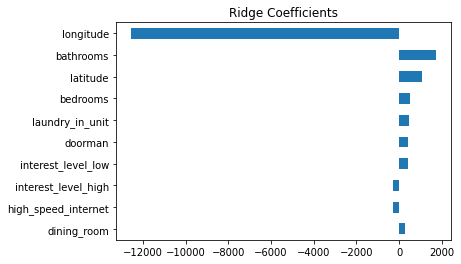

**Note:** Your figure shouldn't be identical to the one above. Your model will have different coefficients since it's been trained on different data. Only the formatting should be the same.